# Uber Taxi Fares Project
![uber](https://images.unsplash.com/photo-1593950315186-76a92975b60c?q=80&w=1887&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D)

**Project Overview** <br>
The Uber Taxi Fares project aims to analyze, explore, clean, and structure the data, and then fit a linear model to understand the relationship between features for better business insights.

**Dataset Overview** <br>
The dataset contains 200,000 samples, each with 7 characteristics. All of them have a data type of float except the `pickup_datetime` and `id`, which are of type int.

**Preparing Data for EDA** <br>
We dropped 1 duplicate column, removed a sample because of missing values, and created the `distance_km` column as it was not provided.

**Exploratory Data Analysis Findings** <br>
We created different visualizations to understand data distribution and characteristics. Some of the findings are:
* The majority of trips have a distance of less than 5 km.
* The fare amount for most trips is between 0 to 20 dollars.
* In the majority of trips, the number of passengers was between 1-6.
* Analysis of trips and revenue per month shows that summer months have fewer trips compared to the whole year.
* The number of trips per day is high on Monday and low on Saturday and Sunday.
* Analyzing the revenue per day shows that Monday has the lowest revenue compared to Friday.
* The mean fare amount with respect to the number of passengers shows no relationship, so we conducted a hypothesis test, which revealed a relationship.

**Linear Regression Model** <br>
To fit the linear regression model, we first removed outliers and engineered some features.

**Outliers** <br>
We removed outliers from the `fare_amount`, `distance_km`, and `passenger_count` columns.

**Feature Engineering** <br>
* Created `day` and `month` columns from the `pickup_datetime` column.
* Created a `rush_hour` column indicating 1 for trips between 6 am-10 am and 4 pm-8 pm.
* Scaled all the variables.

**Fitting the LR Model** <br>
Before fitting the model, we dropped `latitude`, `longitude`, `pickup_datetime`, `day`, and `month` and used only `passenger_count`, `distance_km`, and `rush_hour`.
* After finding the optimal hyperparameters using the grid search method, the model achieved an R² score of 0.61, indicating it explains 61% of the variance in the data.
* Analyzing the coefficients, we concluded:

  *For every 1.42 km traveled, the fare increases by a mean of 2.95 dollars or for every 1 km traveled, the fare increases by a mean of 2.08 dollars.*

**Predictive Model** <br>
After fitting the LR model, we fitted other models to find a predictor for real-time prediction. We engineered additional columns like `daytime`, `nighttime`, `am_rush`, `pm_rush`, etc.
* Applied Random Forest and XGBoost to the data and found that XGBoost outperforms the others with a variance of 0.62, which will be used for prediction purposes.

**Libraries Used** <br>
numpy, pandas, matplotlib, seaborn, scipy, sklearn, xgboost

> **Note: This is the end of the project. If you liked it or found it useful, please upvote it. If you have any suggestions, please let me know.**


In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/uber-fares-dataset/uber.csv


# Data Ingestion and analysis

In [2]:
df = pd.read_csv('/kaggle/input/uber-fares-dataset/uber.csv')

**Data Inspection** <br>
First we will inspect the data including some samples of data, dypes, columns renaming and missing values identification.

In [3]:
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


## Columns renaming and droping

Let's rename the Unnamed to Id and remove the key column as it duplicate of the pickup_datetime

In [4]:
df = df.rename(columns={"Unnamed: 0": "Id"})
df = df.drop(columns = ['key'])

In [5]:
df.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Id                 200000 non-null  int64  
 1   fare_amount        200000 non-null  float64
 2   pickup_datetime    200000 non-null  object 
 3   pickup_longitude   200000 non-null  float64
 4   pickup_latitude    200000 non-null  float64
 5   dropoff_longitude  199999 non-null  float64
 6   dropoff_latitude   199999 non-null  float64
 7   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 12.2+ MB


## Check for missing values

As the info shows that the two cols has missing values. Let's find them.

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

Id                   0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


The dropoff_longitued and dropoff_latitude column has 1 missing value. first we will identify and analyze it.

In [8]:
rows_with_missing = df[df.isnull().any(axis=1)]
rows_with_missing.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
87946,32736015,24.1,2013-07-02 03:51:57 UTC,-73.950581,40.779692,NaN,NaN,0


since this is only one row and passenger_count is also 0, and key is datatime it is a mistake and will remove it.

In [9]:
df = df.dropna()

# Verify that there are no more missing values
print(df.isnull().sum())

Id                   0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## Data type conversion


Since you can see that pickup_datetime is object lets convert it to datetime. first we will import datatime.

In [10]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [11]:
df['pickup_datetime'].head()

0   2015-05-07 19:52:06+00:00
1   2009-07-17 20:04:56+00:00
2   2009-08-24 21:45:00+00:00
3   2009-06-26 08:22:21+00:00
4   2014-08-28 17:47:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

### Distance column creation
As we latitude and longitude and did'nt have the distance column, so let's create one from it. we will use the [haversine method](https://en.wikipedia.org/wiki/Haversine_formula).

In [12]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

# Apply the function to calculate distance for each row
df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'],
                              df['dropoff_latitude'], df['dropoff_longitude'])

In [13]:
df.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


## Exploratory Data Analysis (EDA): <br>
Let explore some statistics of the data. 

In [14]:
df.describe()

,Id,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
count,1.999990e+05,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000,199999.000000
mean,2.771248e+07,11.359892,-72.527631,39.935881,-72.525292,39.923890,1.684543,20.855350
std,1.601386e+07,9.901760,11.437815,7.720558,13.117408,6.794829,1.385995,382.964642
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000000
25%,1.382534e+07,6.000000,-73.992065,40.734796,-73.991407,40.733823,1.000000,1.215222
50%,2.774524e+07,8.500000,-73.981823,40.752592,-73.980093,40.753042,1.000000,2.120992
75%,4.155535e+07,12.500000,-73.967154,40.767158,-73.963658,40.768001,2.000000,3.875169
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,16409.239135


There are significant outliers in fare_amount, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, and passenger_count. For example the minimum fare_amount is -52 (clearly an outlier) and max is 499(too high, an outlier).

### Analyzing Data distributions using Visualizations <br>
Let's create some box plots and histograms for finding the distribution of the data.

<Axes: title={'center': 'distance in km'}, xlabel='distance_km'>

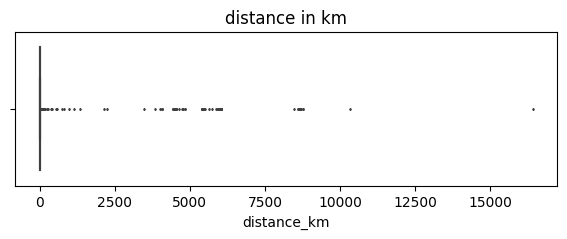

In [15]:
plt.figure(figsize=(7,2))
plt.title('distance in km')
sns.boxplot(data=df, x='distance_km', fliersize=1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


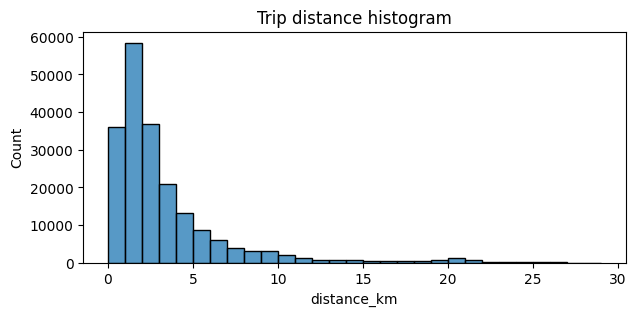

In [16]:
# Create histogram of trip_distance
plt.figure(figsize=(7,3))
sns.histplot(df['distance_km'], bins=range(0,30,1))
plt.title('Trip distance histogram');

The visualization shows that majority of the trips distance were less than 5km.

<Axes: title={'center': 'fare amount'}, xlabel='fare_amount'>

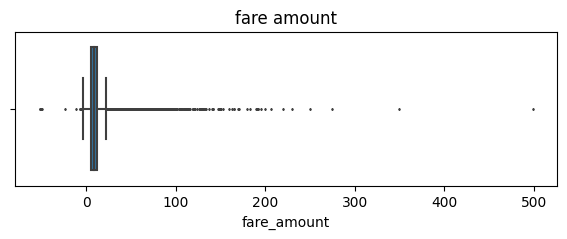

In [17]:
plt.figure(figsize=(7,2))
plt.title('fare amount')
sns.boxplot(data=df, x='fare_amount', fliersize=1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


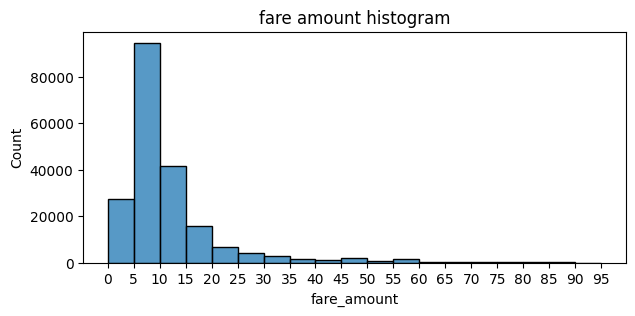

In [18]:
plt.figure(figsize=(7,3))
ax = sns.histplot(df['fare_amount'],bins=range(0,100,5))
ax.set_xticks(range(0,100,5))
ax.set_xticklabels(range(0,100,5))
plt.title('fare amount histogram');

The fare amount is skewed to the right. and the visualization shows that majority of the trips has fare amount of 5-20 dollars.

<Axes: title={'center': 'passenger count'}, xlabel='passenger_count'>

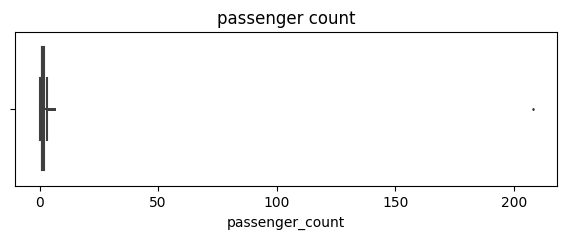

In [19]:
plt.figure(figsize=(7,2))
plt.title('passenger count')
sns.boxplot(data=df, x='passenger_count', fliersize=1)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


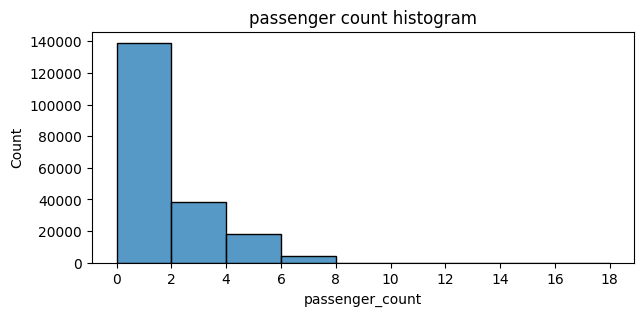

In [20]:
plt.figure(figsize=(7,3))
ax = sns.histplot(df['passenger_count'],bins=range(0,20,2))
ax.set_xticks(range(0,20,2))
ax.set_xticklabels(range(0,20,2))
plt.title('passenger count histogram');

so the 2 passenger per trip is in majority and the passengers counts are upto 8.

### Mean fare amount by passenger count

Now let's examine the fare amount with passenger count.

In [21]:
df['passenger_count'].value_counts()

passenger_count
1      138425
2       29428
5       14009
3        8881
4        4276
6        4271
0         708
208         1
Name: count, dtype: int64

In [22]:
mean_fares_by_passenger_count = df.groupby(['passenger_count']).mean()[['fare_amount']]
mean_fares_by_passenger_count

,fare_amount
passenger_count,
0,9.439266
1,11.254158
2,11.784452
3,11.486731
4,11.642472
5,11.199698
6,12.158537
208,11.700000


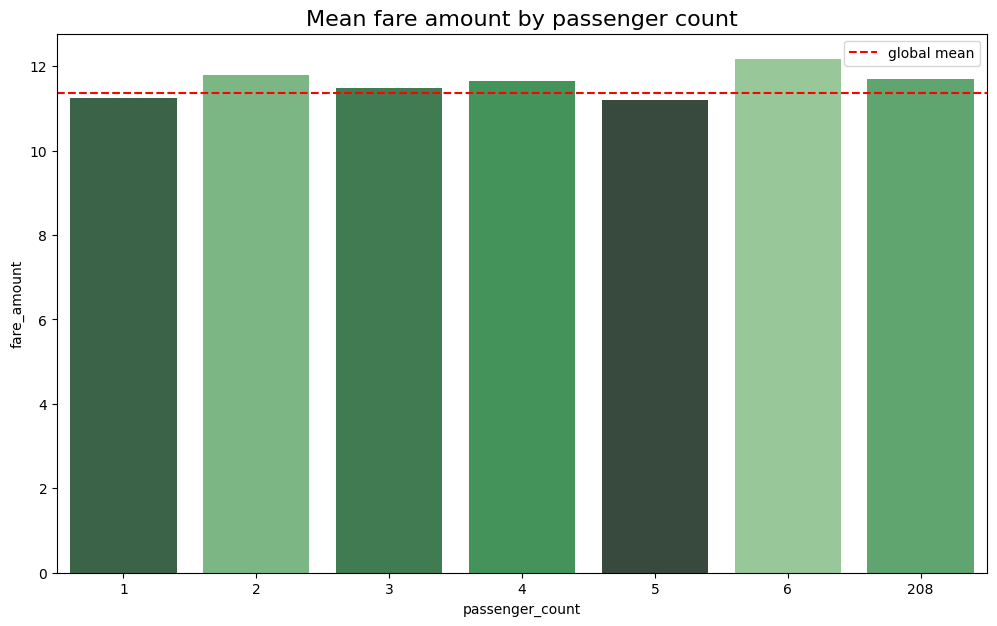

In [23]:
data = mean_fares_by_passenger_count.tail(-1)
pal = sns.color_palette("Greens_d", len(data))
rank = data['fare_amount'].argsort().argsort()
plt.figure(figsize=(12,7))
ax = sns.barplot(x=data.index,
            y=data['fare_amount'],
            palette=np.array(pal[::-1])[rank])
ax.axhline(df['fare_amount'].mean(), ls='--', color='red', label='global mean')
ax.legend()
plt.title('Mean fare amount by passenger count', fontsize=16);

## Feature Engineering: Creating month and day columns by datatime
Now let's create the month and day columns for understanding the data in more details.


In [24]:
# Create a month column
df['month'] = df['pickup_datetime'].dt.month_name()
# Create a day column
df['day'] = df['pickup_datetime'].dt.day_name()

### Monthly rides
Let's analyze rides by months.

In [25]:
monthly_rides = df['month'].value_counts()
monthly_rides

month
May          18859
March        18763
April        18606
June         17787
January      17668
February     16695
October      16212
December     15516
November     15312
September    15266
July         15094
August       14221
Name: count, dtype: int64

let's reorder the months.

In [26]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
         'August', 'September', 'October', 'November', 'December']

monthly_rides = monthly_rides.reindex(index=month_order)
monthly_rides

month
January      17668
February     16695
March        18763
April        18606
May          18859
June         17787
July         15094
August       14221
September    15266
October      16212
November     15312
December     15516
Name: count, dtype: int64

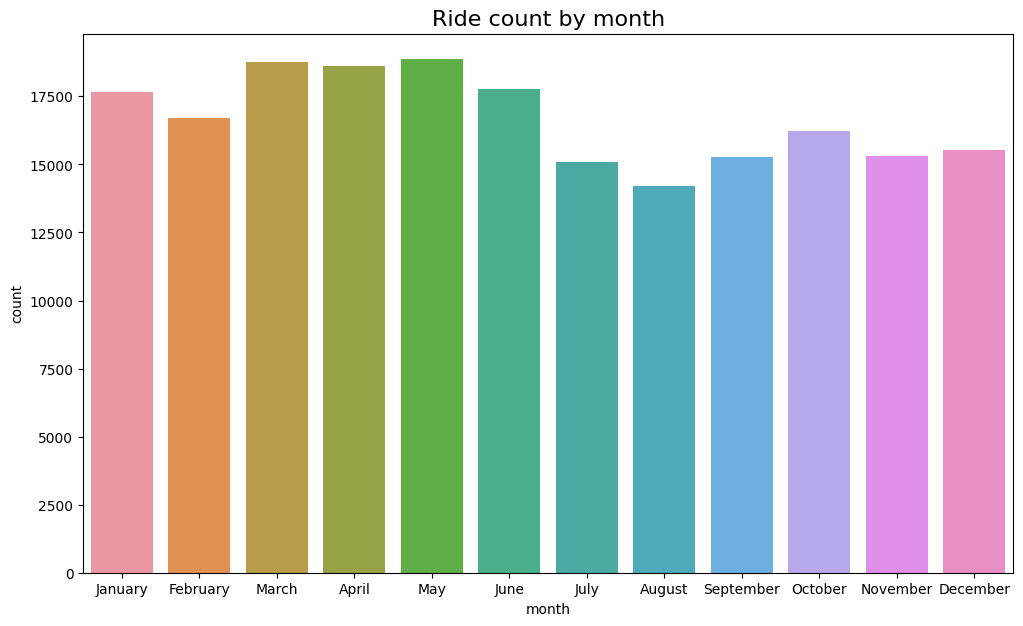

In [27]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x=monthly_rides.index, y=monthly_rides)
ax.set_xticklabels(month_order)
plt.title('Ride count by month', fontsize=16);

The monthly rides are consistent but the summer months July, august and september has some dips.

### Rides per day

In [28]:
daily_rides = df['day'].value_counts()

In [29]:
day_order = ["Monday",'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
daily_rides.reindex(index=day_order)

day
Monday       25243
Tuesday      28126
Wednesday    29037
Thursday     30021
Friday       30880
Saturday     30251
Sunday       26441
Name: count, dtype: int64

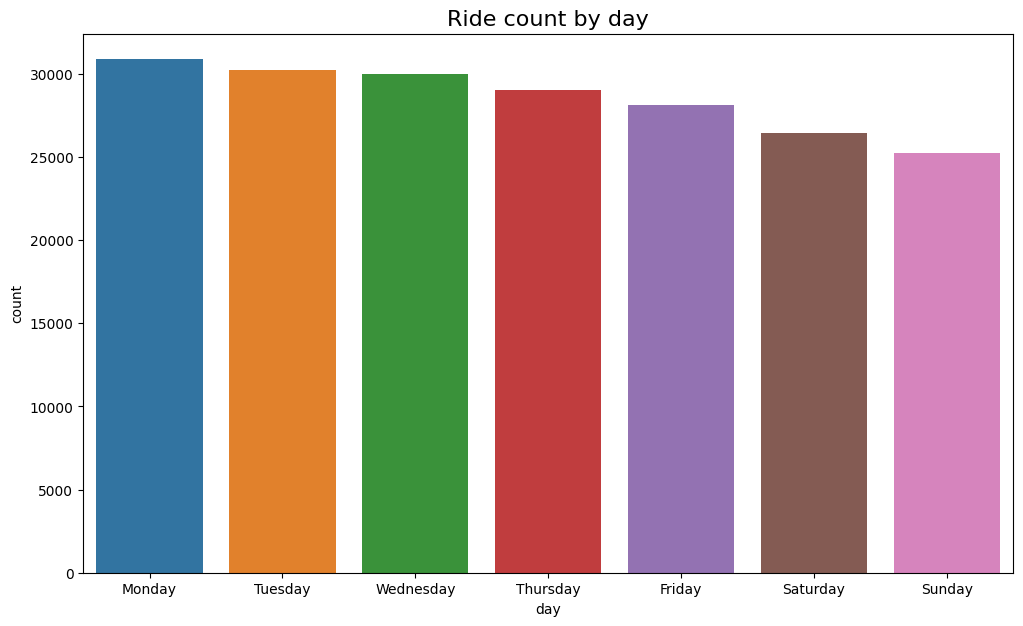

In [30]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x=daily_rides.index, y=daily_rides)
ax.set_xticklabels(day_order)
plt.title('Ride count by day', fontsize=16);

So monday has alot of rides which is obviously start of the week and saturday and sunday has dips dues to holidays.

### Revenue per day

In [31]:
df_without_date = df.drop(columns=['pickup_datetime'])

In [32]:
total_amount_per_day = df_without_date.groupby(by='day').sum()[['fare_amount']]
total_amount_per_day = total_amount_per_day.reindex(index=day_order)

In [33]:
total_amount_per_day

,fare_amount
day,
Monday,287228.19
Tuesday,311504.73
Wednesday,329608.38
Thursday,345774.92
Friday,353260.80
Saturday,333737.30
Sunday,310852.63


Text(0.5, 1.0, 'Revenue by day')

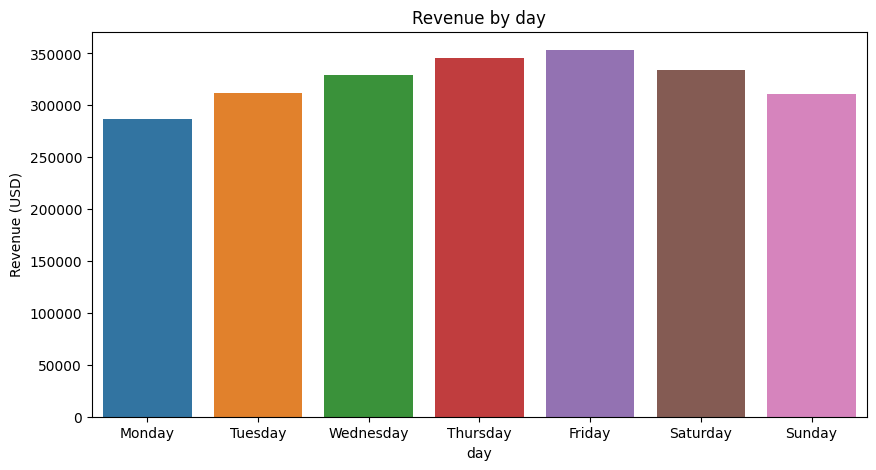

In [34]:
plt.figure(figsize=(10,5))
ax = sns.barplot(x=total_amount_per_day.index,y=total_amount_per_day['fare_amount'])
ax.set_xticklabels(day_order)
ax.set_ylabel("Revenue (USD)")
plt.title("Revenue by day")

The revenure is high for takes a peak at thursday and friday while other has less. and the rides are high on mondays which is quite interesting.

### Revenue per month

In [35]:
total_amount_per_month = df_without_date.groupby(by='month').sum()[['fare_amount']]
total_amount_per_month = total_amount_per_month.reindex(index=month_order)
total_amount_per_month

,fare_amount
month,
January,189499.77
February,182453.99
March,208300.37
April,210972.89
May,220246.02
June,206421.84
July,168454.49
August,159351.40
September,180011.21


Text(0.5, 1.0, 'Revenue by Month')

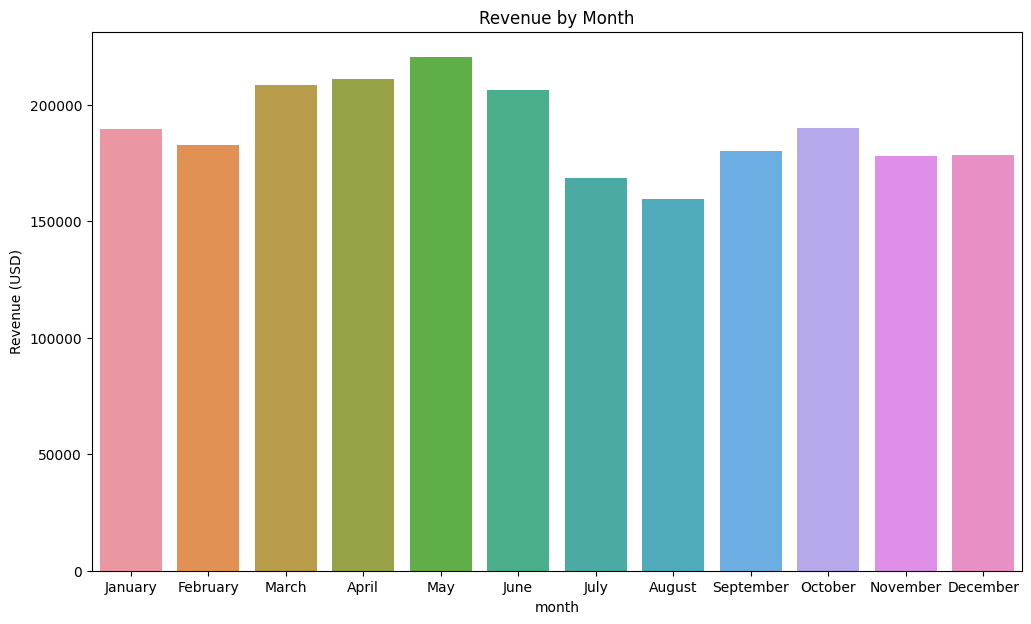

In [36]:
plt.figure(figsize=(12,7))
ax = sns.barplot(x=total_amount_per_month.index,y=total_amount_per_month['fare_amount'])
ax.set_xticklabels(month_order)
ax.set_ylabel("Revenue (USD)")
plt.title("Revenue by Month")

The revenue per month shows that summer months July, August and september has less revenue than other as shown by trips per month.

## hypothesis test for fare amount relationship with passenger count
As above we have seen mean fare amount with passenger count which shows the same mean for all. so let's test wether they have a relationship or not.

In [37]:
from scipy import stats

In [38]:
df.describe()[['fare_amount','passenger_count']]

,fare_amount,passenger_count
count,199999.000000,199999.000000
mean,11.359892,1.684543
std,9.901760,1.385995
min,-52.000000,0.000000
25%,6.000000,1.000000
50%,8.500000,1.000000
75%,12.500000,2.000000
max,499.000000,208.000000


In [39]:
df.groupby('passenger_count')[['fare_amount']].mean()

,fare_amount
passenger_count,
0,9.439266
1,11.254158
2,11.784452
3,11.486731
4,11.642472
5,11.199698
6,12.158537
208,11.700000


As we can see the values of passenger count and fare amount are consistent and we don't see any relationship, but it can be because of random sampling. To find wether these values are statistically significant, let's do some hypothesis testing.

**Hypothesis** <br>
Null Hypothesis: There is no difference between average fare amount based on the no of passenger. <br>
Alternative Hypothesis: There is difference between average fare amount based on the no of passenger. 

In [40]:
one_passenger = df[df['passenger_count'] == 1]['fare_amount']
two_passenger = df[df['passenger_count'] == 2]['fare_amount']
three_passenger = df[df['passenger_count'] == 3]['fare_amount']
four_passenger = df[df['passenger_count'] == 4]['fare_amount']
five_passenger = df[df['passenger_count'] == 5]['fare_amount']
six_passenger = df[df['passenger_count'] == 6]['fare_amount']

In [41]:
result = stats.f_oneway(one_passenger,two_passenger,three_passenger,four_passenger,five_passenger,six_passenger)
print("F-statistic:", result.statistic)
print("p-value:", result.pvalue)

F-statistic: 21.20953546719199
p-value: 2.838724710616687e-21


Since the p-value is less than significance level 0.05, so we reject the null hypothesis and conclude that there is a significant difference in the average fare amount based on the number of passengers.

## Linear regression model

As we have removed missing values now let's analyze duplicates.

In [42]:
df1 = df.copy()

In [43]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,May,Thursday
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,July,Friday
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,August,Monday
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,June,Friday
4,17610152,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,4.475450,August,Thursday


In [44]:
df1.duplicated().sum()

0

so we have no duplicates and missing values, now we will find and remove outlier from the data because the machine learning models are effected by them.

In [45]:
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'],format='%m/%d/%Y %I:%M:%S %p')

In [46]:
df1['pickup_datetime'].head()

0   2015-05-07 19:52:06+00:00
1   2009-07-17 20:04:56+00:00
2   2009-08-24 21:45:00+00:00
3   2009-06-26 08:22:21+00:00
4   2014-08-28 17:47:00+00:00
Name: pickup_datetime, dtype: datetime64[ns, UTC]

Now our main features would be fare amount, distance, passenger count, so let's see the outliers in them.

### Removing Outline for LR model

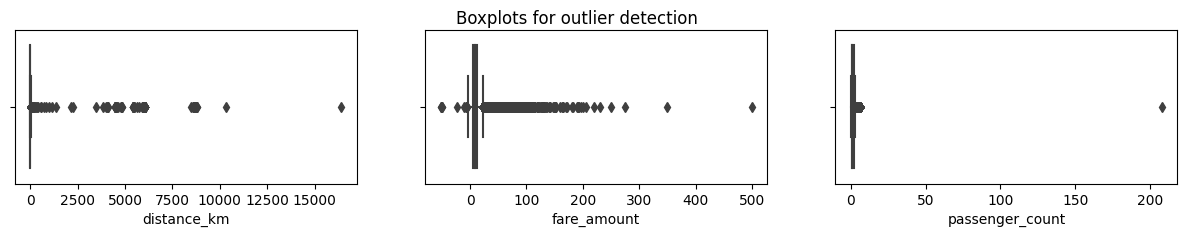

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(15, 2))
fig.suptitle('Boxplots for outlier detection')
sns.boxplot(ax=axes[0], x=df1['distance_km'])
sns.boxplot(ax=axes[1], x=df1['fare_amount'])
sns.boxplot(ax=axes[2], x=df1['passenger_count'])
plt.show();

so the fare_amount and distance has values in negatives also.

In [48]:
sum(df1['distance_km']==0)

5632

5 Thousand trips has distance of 0.

In [49]:
df1['fare_amount'].describe()

count    199999.000000
mean         11.359892
std           9.901760
min         -52.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         499.000000
Name: fare_amount, dtype: float64

The min is -52 so we can make it 0 but the max is 499 which is unreal.

In [50]:
def outlier_imputer(df, column_list, iqr_factor):
    df_copy = df.copy()  # Work on a copy of the dataframe
    
    for col in column_list:
        q1 = df_copy[col].quantile(0.25)
        q3 = df_copy[col].quantile(0.75)
        iqr = q3 - q1
        upper_threshold = q3 + (iqr_factor * iqr)
        lower_threshold = q1 - (iqr_factor * iqr)
        
        print(col)
        print('q3:', q3)
        print('upper_threshold:', upper_threshold)
        
        print('q1:', q1)
        print('lower_threshold:', lower_threshold)

        # Filter out outliers
        df_copy = df_copy[(df_copy[col] <= upper_threshold) & (df_copy[col] >= lower_threshold)]
        print(df_copy[col].describe())
        print()
    
    return df_copy

In [51]:
df1 = outlier_imputer(df1, ['fare_amount','distance_km','passenger_count'], 1.5)

fare_amount
q3: 12.5
upper_threshold: 22.25
q1: 6.0
lower_threshold: -3.75
count    182833.000000
mean          8.940095
std           4.143264
min          -3.500000
25%           5.700000
50%           8.000000
75%          11.000000
max          22.200000
Name: fare_amount, dtype: float64

distance_km
q3: 3.2827774817668756
upper_threshold: 6.4631959656428295
q1: 1.1624984925162398
lower_threshold: -2.0179199913597143
count    174540.000000
mean          2.218767
std           1.454764
min           0.000000
25%           1.131295
50%           1.876565
75%           3.030305
max           6.463182
Name: distance_km, dtype: float64

passenger_count
q3: 2.0
upper_threshold: 3.5
q1: 1.0
lower_threshold: -0.5
count    154869.000000
mean          1.259942
std           0.548312
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
Name: passenger_count, dtype: float64



In [52]:
df1.shape

(154869, 11)

Now we have date, month and day columns let's lower case them and  find rush hours in the data.

In [53]:
df1.columns

Index(['Id', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km', 'month', 'day'],
      dtype='object')

In [54]:
df1['day'] = df1['day'].str.lower()
df1['month'] = df1['pickup_datetime'].dt.strftime('%b').str.lower()

In [55]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday


### Feature Engineering: Creating Rush hour column

In [56]:
df1['rush_hour'] = df1['pickup_datetime'].dt.hour

In [57]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day,rush_hour
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday,19
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday,20
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday,21
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday,8
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday,2


In [58]:
df1.loc[df1['day'].isin(['saturday', 'sunday']), 'rush_hour'] = 0

In [59]:
def rush_hourizer(hour):
    if 6 <= hour['rush_hour'] < 10:
        val = 1
    elif 16 <= hour['rush_hour'] < 20:
        val = 1
    else:
        val = 0
    return val

In [60]:
df1.loc[(df1.day != 'saturday') & (df1.day != 'sunday'), 'rush_hour'] = df1.apply(rush_hourizer, axis=1).astype('int32')

df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day,rush_hour
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday,0
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday,0
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday,1
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday,0


In [61]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day,rush_hour
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday,0
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday,0
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday,1
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday,0


In [62]:
df1.columns

Index(['Id', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'distance_km', 'month', 'day', 'rush_hour'],
      dtype='object')

In [63]:
df2 = df1.drop(['Id', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude','day', 'month'],axis=1)
df2.head()

,fare_amount,passenger_count,distance_km,rush_hour
0,7.5,1,1.683323,1
1,7.7,1,2.457590,0
2,12.9,1,5.036377,0
3,5.3,3,1.661683,1
5,4.9,1,0.000000,0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

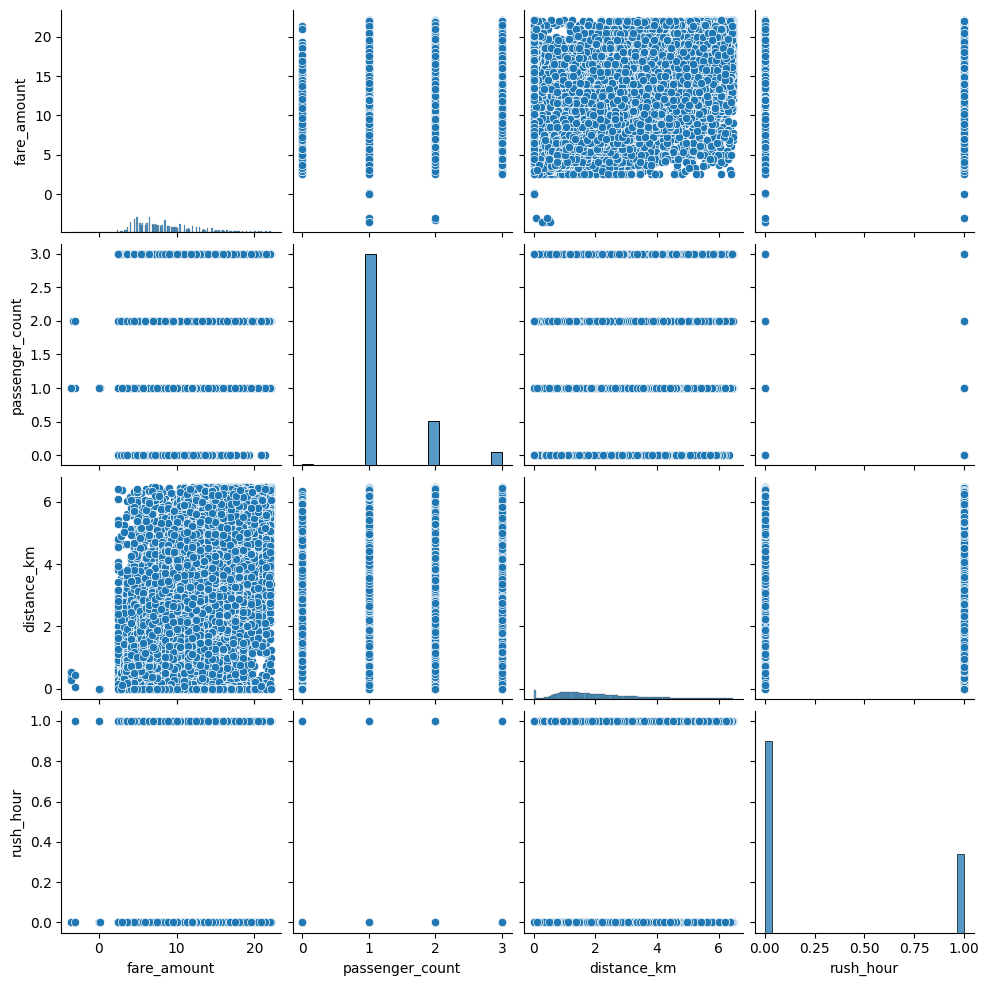

In [64]:
sns.pairplot(df2);

In [65]:
df2.corr(method='pearson')

,fare_amount,passenger_count,distance_km,rush_hour
fare_amount,1.000000,0.018304,0.754841,-0.010957
passenger_count,0.018304,1.000000,0.012573,-0.057370
distance_km,0.754841,0.012573,1.000000,-0.040627
rush_hour,-0.010957,-0.057370,-0.040627,1.000000


In [66]:
df2['rush_hour'] = df2['rush_hour'].astype(float)

In [67]:
df2.shape

(154869, 4)

### Removing the rows with 0 distance

In [68]:
df2 = df2[df2['distance_km']!=0].reindex()

In [69]:
df2.shape

(150334, 4)

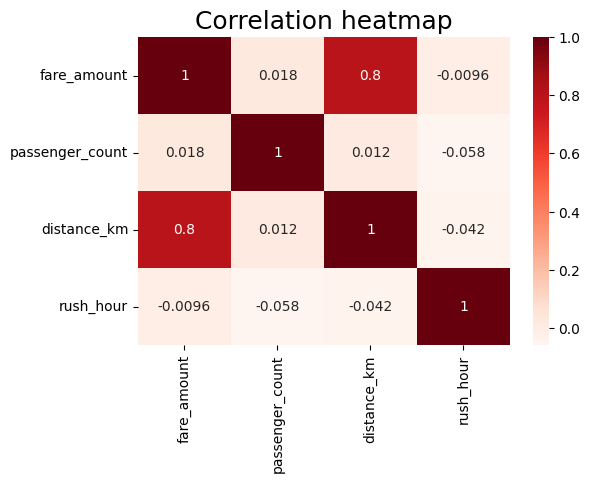

In [70]:

plt.figure(figsize=(6,4))
sns.heatmap(df2.corr(method='pearson'), annot=True, cmap='Reds')
plt.title('Correlation heatmap',
          fontsize=18)
plt.show()

### Create features and target

In [71]:
X = df2.drop(columns=['fare_amount'])

# Set y variable
y = df2[['fare_amount']]

In [72]:
X.head()

,passenger_count,distance_km,rush_hour
0,1,1.683323,1.0
1,1,2.457590,0.0
2,1,5.036377,0.0
3,3,1.661683,1.0
8,1,2.332711,1.0


In [73]:
X[X['distance_km']==0].head()

,passenger_count,distance_km,rush_hour


### sklearn Imports

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics # For confusion matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

### Split between train and test sets

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

### Scaling Data

In [76]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
print('X_train scaled:', X_train_scaled)

X_train scaled: [[-0.47525458  0.04439963 -0.64148809]
 [-0.47525458 -0.27870613  1.55887541]
 [-0.47525458  0.20015523 -0.64148809]
 ...
 [-0.47525458  2.0666192   1.55887541]
 [ 1.34715627  0.36458155 -0.64148809]
 [-0.47525458 -0.9281082  -0.64148809]]


### Fitting LR model

In [77]:
lr=LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [78]:
r_sq = lr.score(X_train_scaled, y_train)
print('Coefficient of determination:', r_sq)
y_pred_train = lr.predict(X_train_scaled)
print('R^2:', r2_score(y_train, y_pred_train))
print('MAE:', mean_absolute_error(y_train, y_pred_train))
print('MSE:', mean_squared_error(y_train, y_pred_train))
print('RMSE:',np.sqrt(mean_squared_error(y_train, y_pred_train)))

Coefficient of determination: 0.6349451317288373
R^2: 0.6349451317288373
MAE: 1.607698085551465
MSE: 5.030403418185143
RMSE: 2.242856085036475


In [79]:
X_test_scaled = scaler.transform(X_test)

In [80]:
r_sq_test = lr.score(X_test_scaled, y_test)
print('Coefficient of determination:', r_sq_test)
y_pred_test = lr.predict(X_test_scaled)
print('R^2:', r2_score(y_test, y_pred_test))
print('MAE:', mean_absolute_error(y_test,y_pred_test))
print('MSE:', mean_squared_error(y_test, y_pred_test))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred_test)))

Coefficient of determination: 0.615963549289686
R^2: 0.615963549289686
MAE: 1.6359273588427357
MSE: 5.305738442177699
RMSE: 2.3034188594733913


### Evaluating wether LR is good for this data or not?

In [81]:
results = pd.DataFrame(data={'actual': y_test['fare_amount'],
                             'predicted': y_pred_test.ravel()})
results['residual'] = results['actual'] - results['predicted']
results.head()

,actual,predicted,residual
43530,5.7,6.733581,-1.033581
25500,8.5,8.026261,0.473739
144453,5.0,5.611058,-0.611058
14117,4.5,5.888021,-1.388021
155218,4.9,5.886377,-0.986377


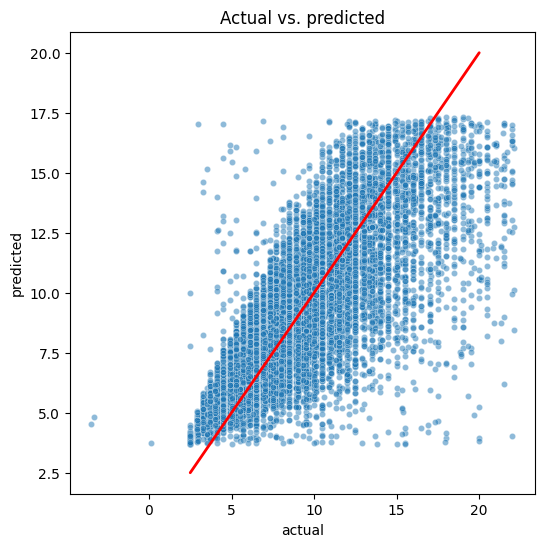

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set(style='whitegrid')
sns.scatterplot(x='actual',
                y='predicted',
                data=results,
                s=20,
                alpha=0.5,
                ax=ax
)
# Draw an x=y line to show what the results would be if the model were perfect
plt.plot([2.5,20], [2.5,20], c='red', linewidth=2)
plt.title('Actual vs. predicted');

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


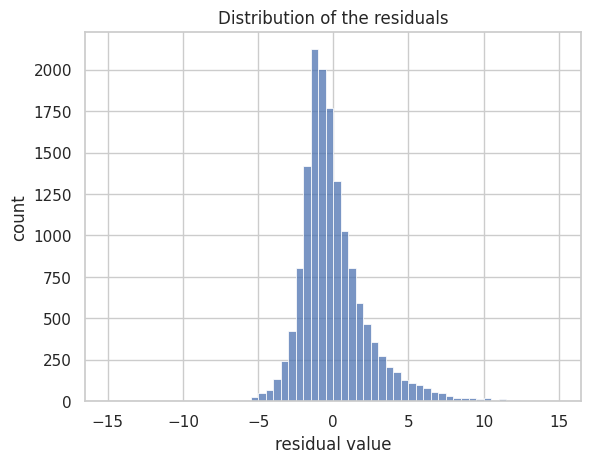

In [83]:
# Visualize the distribution of the `residuals`
sns.histplot(results['residual'], bins=np.arange(-15,15.5,0.5))
plt.title('Distribution of the residuals')
plt.xlabel('residual value')
plt.ylabel('count');

In [84]:
results['residual'].mean()

-0.008943627953387495

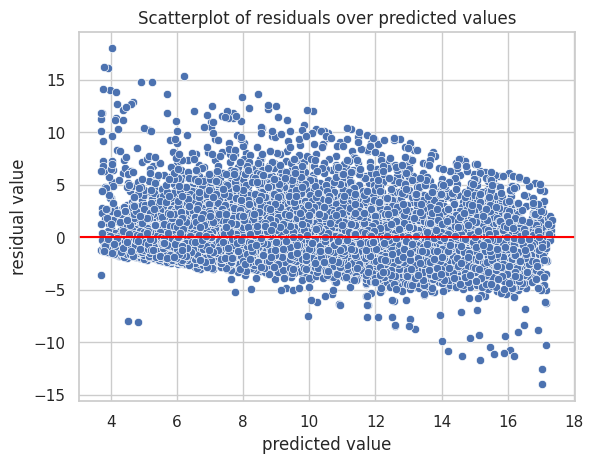

In [85]:

sns.scatterplot(x='predicted', y='residual', data=results)
plt.axhline(0, c='red')
plt.title('Scatterplot of residuals over predicted values')
plt.xlabel('predicted value')
plt.ylabel('residual value')
plt.show()

In [86]:
coefficients = pd.DataFrame(lr.coef_, columns=X.columns)
coefficients

,passenger_count,distance_km,rush_hour
0,0.034787,2.959849,0.092767


In [87]:
print(X_train['distance_km'].std())

# 2. Divide the model coefficient by the standard deviation
print(2.959849 / X_train['distance_km'].std())

1.4223114110654356
2.081013325895216


### Finding from the LR model

so according to the data for every 1.42 km traveled the fare increase by a mean of 2.95 or for every 1 km traveled the fare increased by a mean of 2.08 dollars.

## Training Model for prediction purpose

In [88]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# This is the function that helps plot feature importance 
from xgboost import plot_importance

In [89]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day,rush_hour
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday,1
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday,0
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday,0
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday,1
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday,0


### Feature Engineering

In [90]:
# Create 'am_rush' col
df1['am_rush'] = df1['pickup_datetime'].dt.hour

# Create 'daytime' col
df1['daytime'] = df1['pickup_datetime'].dt.hour

# Create 'pm_rush' col
df1['pm_rush'] = df1['pickup_datetime'].dt.hour

# Create 'nighttime' col
df1['nighttime'] = df1['pickup_datetime'].dt.hour

In [91]:
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

In [92]:
# Apply 'am_rush' function to the 'am_rush' series
df1['am_rush'] = df1.apply(am_rush, axis=1)
df1['am_rush'].head()

0    0
1    0
2    0
3    1
5    0
Name: am_rush, dtype: int64

In [93]:
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [94]:
df1['daytime'] = df1.apply(daytime, axis=1)

In [95]:
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [96]:
df1['pm_rush'] = df1.apply(pm_rush, axis=1)

In [97]:
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [98]:
df1['nighttime'] = df1.apply(nighttime, axis=1)

In [99]:
df1.head()

,Id,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,month,day,rush_hour,am_rush,daytime,pm_rush,nighttime
0,24238194,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,1.683323,may,thursday,1,0,0,1,0
1,27835199,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,2.457590,jul,friday,0,0,0,0,1
2,44984355,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,5.036377,aug,monday,0,0,0,0,1
3,25894730,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,1.661683,jun,friday,1,1,0,0,0
5,44470845,4.9,2011-02-12 02:27:09+00:00,-73.969019,40.755910,-73.969019,40.755910,1,0.000000,feb,saturday,0,0,0,0,1


In [100]:
drop_columns = ['Id','pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','rush_hour']
df1 = df1.drop(drop_columns,axis=1)
df1.head()

,fare_amount,passenger_count,distance_km,month,day,am_rush,daytime,pm_rush,nighttime
0,7.5,1,1.683323,may,thursday,0,0,1,0
1,7.7,1,2.457590,jul,friday,0,0,0,1
2,12.9,1,5.036377,aug,monday,0,0,0,1
3,5.3,3,1.661683,jun,friday,1,0,0,0
5,4.9,1,0.000000,feb,saturday,0,0,0,1


In [101]:
df1 = pd.get_dummies(df1, drop_first=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154869 entries, 0 to 199999
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   fare_amount      154869 non-null  float64
 1   passenger_count  154869 non-null  int64  
 2   distance_km      154869 non-null  float64
 3   am_rush          154869 non-null  int64  
 4   daytime          154869 non-null  int64  
 5   pm_rush          154869 non-null  int64  
 6   nighttime        154869 non-null  int64  
 7   month_aug        154869 non-null  bool   
 8   month_dec        154869 non-null  bool   
 9   month_feb        154869 non-null  bool   
 10  month_jan        154869 non-null  bool   
 11  month_jul        154869 non-null  bool   
 12  month_jun        154869 non-null  bool   
 13  month_mar        154869 non-null  bool   
 14  month_may        154869 non-null  bool   
 15  month_nov        154869 non-null  bool   
 16  month_oct        154869 non-null  bool   
 

In [102]:
X = df1.drop(['fare_amount'],axis=1)
y = df1[['fare_amount']]

In [103]:
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [104]:
X_train.shape

(108408, 23)

In [105]:
y_train.shape

(108408, 1)

## Random Forest Model

In [106]:
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(random_state=42)
 
# # Fit the regressor with x and y data
# regressor.fit(X_train, y_train)

In [107]:
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [0.7],
             'min_samples_leaf': [1],
             'min_samples_split': [2],
             'n_estimators': [300]
             }

# 3. Define a set of scoring metrics to capture
scoring = {'r2','accuracy'}

# 4. Instantiate the GridSearchCV object
rf1 = GridSearchCV(regressor, cv_params, scoring=scoring, cv=4,refit='r2')

In [108]:
# rf1.fit(X_train, y_train.ravel())

In [109]:
# rf1.best_score_

In [110]:
# rf1.best_params_

In [111]:
random_forest = RandomForestRegressor(max_depth= None,
 max_features= 1.0,
 max_samples= 0.7,
 min_samples_leaf= 1,
 min_samples_split= 2,
 n_estimators=300)

In [112]:
random_forest.fit(X_train,y_train)

/tmp/ipykernel_18/363313747.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train,y_train)


RandomForestRegressor(max_samples=0.7, n_estimators=300)

In [113]:

# Evaluating the model
from sklearn.metrics import mean_squared_error, r2_score
 
# Making predictions on the same data or new data
predictions = random_forest.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 5.680322223258309
R-squared: 0.5870029393078449


### Random Forest Findings
The r-squared value is 0.58. Now let's try the xgboost.

## Gradient Boost Model

In [114]:
# 1. Instantiate the XGBoost
xgb = XGBRegressor(objective ='reg:squarederror',random_state=42, learning_rate = 0.02, max_depth = 8,min_child_weight= 4,
 n_estimators = 200)

# 2. Create a dictionary of hyperparameters to tune
# Note that this example only contains 1 value for each parameter for simplicity,
# but you should assign a dictionary with ranges of values
# cv_params = {'learning_rate': [0.1,0.01,0.02],
#              'max_depth': [8,9,11],
#              'min_child_weight': [2,3,4],
#              'n_estimators': [500,200,300,600]
#              }

# 3. Define a set of scoring metrics to capture
# scoring = {'accuracy', 'r2'}

# 4. Instantiate the GridSearchCV object
# xgb1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='r2')

In [115]:
y_train.shape

(108408, 1)

In [116]:
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [117]:
# Making predictions on the same data or new data
predictions = xgb.predict(X_test)
 
# Evaluating the model
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, predictions)
print(f'R-squared: {r2}')

Mean Squared Error: 5.102603826157649
R-squared: 0.6290068944590888


### XGB findings
The xgb covers 0.62 variance of the data.

## Model Exporting

In [118]:
import pickle
with open('/kaggle/working/' + 'gradient_boost' + '.pickle', 'wb') as to_write:
        pickle.dump(xgb, to_write)

In [119]:
def read_pickle(path, saved_model_name:str):
    '''
    saved_model_name is a string.
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

        return model

In [120]:
model = read_pickle('/kaggle/working/','gradient_boost')

In [121]:
X_test.head()

,passenger_count,distance_km,am_rush,daytime,pm_rush,nighttime,month_aug,month_dec,month_feb,month_jan,...,month_may,month_nov,month_oct,month_sep,day_monday,day_saturday,day_sunday,day_thursday,day_tuesday,day_wednesday
151695,2,3.204652,0,0,0,1,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
164471,1,2.371665,0,0,0,1,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
99363,2,0.747529,0,1,0,0,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
135597,1,1.615625,1,0,0,0,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
26267,1,0.531467,0,1,0,0,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False


In [122]:
model.predict(X_test.head())

array([10.011554 ,  8.2308655,  5.1420784,  7.3280916,  4.7318716],
      dtype=float32)

In [123]:
y_test.head(5)

,fare_amount
151695,9.0
164471,7.3
99363,4.1
135597,8.9
26267,4.0
